# 영화 추천 🎥과 이동진 평론가의 한줄평을 함께!

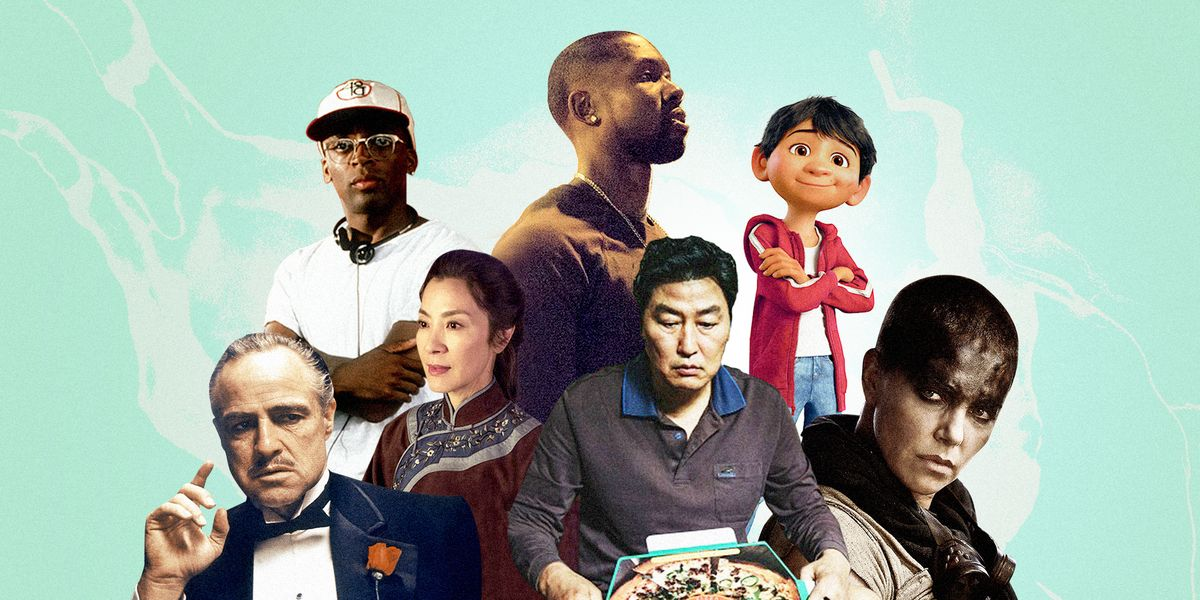

## 분석 배경 및 내용
> 일상생활을 하다보면 유튜브, 넷플릭스, 쿠팡 등 많은 부분에서 추천 알고리즘의 도움을 받게 됩니다. 저도 평소 영화를 고를 때 추천 알고리즘의 도움을 많이 받지만 이동진 평론가의 도움도 자주 받습니다. 그러던 중 이동진 평론가가 남긴 평점과 한줄평을 함께 보는 영화 추천 시스템을 만들어 보고 싶어 해당 프로젝트를 진행하게 되었습니다.

1. ``네이버 블로그, 네이버 API와 Kaggle을 통해 데이터 수집``을 진행했습니다. 데이터는 영화 제목(한/영), 개봉년도, 장르, 네이버 평점, IMDB 평점, 해당 평점에 투표한 IMDB 유저의 수, 이동진 평론가의 평점, 감독, 주연 배우, 이동진 평론가의 한줄평으로 구성되어있습니다.

2. ``특이값 분해와 코사인 유사도를 활용한 하이브리드 기반의 추천 알고리즘``을 채택하였습니다. 초기엔 코사인 유사도를 활용한 콘텐츠 기반의 추천 필터링만을 적용했습니다. 하지만 개인화된 추천과 다양한 추천 목록을 제공하고 싶어 하이브리드 기반의 추천 알고리즘으로 변경하게 되었습니다.

3. ``유저의 ID``와 ``영화 제목``이 주어지면 ``해당 유저의 취향에 알맞는 영화를 10개 추천``해줍니다.

In [1]:
# 라이브러리 불러오기
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ast import literal_eval
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer

from surprise import SVD, Reader
from surprise import Dataset
from surprise import accuracy
from surprise.model_selection import cross_validate, train_test_split
from surprise.dataset import DatasetAutoFolds
sns.set_style('darkgrid')
import warnings
warnings.filterwarnings('ignore')

# 사용자 운영체제 확인
import platform
platform.system()
# 운영체제별 한글 폰트 설정
if platform.system() == 'Darwin': # Mac 환경 폰트 설정
    plt.rc('font', family='AppleGothic')
elif platform.system() == 'Windows': # Windows 환경 폰트 설정
    plt.rc('font', family='Malgun Gothic')

plt.rc('axes', unicode_minus=False) # 마이너스 폰트 설정


# 글씨 선명하게 출력하는 설정
%config InlineBackend.figure_format = 'retina'

pd.set_option('display.max.colwidth', 50)

In [2]:
# 데이터 불러오기
md = pd.read_csv('imdb.csv', encoding = 'cp949')

# 네이버 영화 평점이 10점이거나 0점인 데이터 제외
md = md.loc[(md['naver rating'] != 10) & (md['naver rating'] != 0)].reset_index(drop = True)
print(md.shape)
md.loc[md['title'] == '기생충']

(5071, 12)


,id,title,subtitle,publication date,genres,naver rating,imdb rating,vote_count,critic_rating,director,actor,review
4380,468708,기생충,PARASITE,2019,드라마 스릴러,8.48,NaN,NaN,4.5,봉준호,송강호 이선균 조여정 최우식 박소담 이정은 장혜진,상승과 하강으로 명징하게 직조해낸 신랄하면서 처연한 계급 우화.


- id: 영화 고유의 ID
- title: 영화의 한국어 제목
- subtitle: 영화의 영어 제목
- publication date: 개봉년도
- genres: 영화 장르
- naver rating: 네이버 영화의 영화 평점
- imdb rating: IMDB의 영화 평점
- vote_count: 해당 영화에 평점을 부여한 IMDB 유저의 수
- critic_rating: 이동진 평론가의 영화 평점
- director: 영화 감독
- actor: 주연 배우
- review: 이동진 평론가의 한줄평

In [3]:
# 결측치 확인
md.isnull().sum()

id                     0
title                  0
subtitle              17
publication date       0
genres                 3
naver rating           0
imdb rating          691
vote_count           691
critic_rating       3038
director               1
actor                 46
review              3998
dtype: int64

In [4]:
def preprocess(df):
    # 장르, 감독, 배우의 결측치는 공백으로 처리
    df['genres'].fillna('', inplace = True)
    df['director'].fillna('', inplace = True)
    df['actor'].fillna('', inplace = True)
    
    # 감독은 2배의 가중치를 줌.
    df['director'] = df['director'].apply(lambda x: [x, x])
    df['director'] = df['director'].apply(lambda x : (' ').join(x))
    
    # 주연 배우도 2배의 가중치.
    df['actor'] = df['actor'].apply(lambda x: [x, x])
    df['actor'] = df['actor'].apply(lambda x : (' ').join(x))

    # 장르, 감독, 배우에 기반한 코사인 유사도를 구하기 위해 content 컬럼 생성
    df['content'] = df['genres'] + ' ' + df['director'] + ' ' + df['actor']
    
    return df

md = preprocess(md)
md.loc[md['title'] == '기생충']

,id,title,subtitle,publication date,genres,naver rating,imdb rating,vote_count,critic_rating,director,actor,review,content
4380,468708,기생충,PARASITE,2019,드라마 스릴러,8.48,NaN,NaN,4.5,봉준호 봉준호,송강호 이선균 조여정 최우식 박소담 이정은 장혜진 송강호 이선균 조여정 최우식 박소...,상승과 하강으로 명징하게 직조해낸 신랄하면서 처연한 계급 우화.,드라마 스릴러 봉준호 봉준호 송강호 이선균 조여정 최우식 박소담 이정은 장혜진 송강...


## 콘텐츠 기반 필터링?

콘텐츠 기반 필터링은 좋아하는 상품들과 유사한 상품들을 추천하는 방법입니다. 이때의 핵심은 콘텐츠(Items)들을 벡터 형태로 표현한다는 것입니다. <b>왜 벡터 형태로 표현하냐면 유사도를 구하기 위함입니다.</b> 유클리드 유사도, 피어슨 유사도 등이 많은 방법이 있지만 대표적으로 [코사인 유사도](https://ko.wikipedia.org/wiki/%EC%BD%94%EC%82%AC%EC%9D%B8_%EC%9C%A0%EC%82%AC%EB%8F%84)를 사용한다고 합니다. 이러한 이유는 코사인 유사도는 벡터의 방향을 중시하기 때문이라고 합니다. 이제 전처리 함수를 통해 만든 content의 단어의 빈도수를 통해 코사인 유사도를 구할 것입니다.

In [5]:
# count vecotrizer를 통해 빈도 수 구하기
count_vect = CountVectorizer(min_df=0, ngram_range=(1,2))
content_mat = count_vect.fit_transform(md['content'])
print(content_mat.shape)

(5071, 37584)


In [6]:
# 이해를 돕기 위한 예시
fruit_list = ['사과 딸기', '딸기 바나나', '수박', '수박 수박'] 
# '딸기', '딸기 바나나', '바나나', '사과', '사과 딸기', '수박', '수박 수박'
cv = CountVectorizer(min_df=0, ngram_range=(1, 2)) 
fruit_vector = cv.fit_transform(fruit_list)
pd.DataFrame(fruit_vector.toarray(), index = fruit_list, columns = ['딸기', '딸기 바나나', '바나나', '사과', '사과 딸기', '수박', '수박 수박'])

,딸기,딸기 바나나,바나나,사과,사과 딸기,수박,수박 수박
사과 딸기,1,0,0,1,1,0,0
딸기 바나나,1,1,1,0,0,0,0
수박,0,0,0,0,0,1,0
수박 수박,0,0,0,0,0,2,1


In [7]:
# 과일들의 코사인 유사도
pd.DataFrame(cosine_similarity(fruit_vector, fruit_vector), index = fruit_list, columns = fruit_list)

,사과 딸기,딸기 바나나,수박,수박 수박
사과 딸기,1.000000,0.333333,0.000000,0.000000
딸기 바나나,0.333333,1.000000,0.000000,0.000000
수박,0.000000,0.000000,1.000000,0.894427
수박 수박,0.000000,0.000000,0.894427,1.000000


In [8]:
# 코사인 유사도 구하기
cosine_sim = cosine_similarity(content_mat, content_mat)

# 코사인 유사도가 큰 순서로 정렬 -> index를 보여줌
content_sim_sorted_ind = cosine_sim.argsort()[:, ::-1]

# 그렇다면 '기생충'과 유사한 콘텐츠의 인덱스는?
print(content_sim_sorted_ind[4380])

[4380 4671  822 ... 2328 2329 2535]


In [9]:
md.iloc[4671]

id                                                       468999
title                                                    살인의 추억
subtitle                                     Memories Of Murder
publication date                                           2003
genres                                      범죄 미스터리 스릴러 코미디 드라마
naver rating                                               9.41
imdb rating                                                 NaN
vote_count                                                  NaN
critic_rating                                               5.0
director                                                봉준호 봉준호
actor                                           송강호 김상경 송강호 김상경
review                            한국영화계가 2003년을 자꾸 되돌아보는 가장 큰 이
content             범죄 미스터리 스릴러 코미디 드라마 봉준호 봉준호 송강호 김상경 송강호 김상경
Name: 4671, dtype: object

### 영화 추천
이제 코사인 유사도를 통해 해당 영화와 비슷한 영화들을 추천해볼 것입니다. 그런데 유저가 봤을 때 인상 깊은 영화를 추천해야 좋은 서비스겠죠? 이를 위해서 높은 유사도를 가진 영화 중에서 평점도 괜찮은 영화들을 추천해보려고 합니다. 저희 데이터에는 Naver 평점과 IMDB 평점, 이동진 평론가의 평점이 있습니다. 세 가지 중 어떤 것을 사용해야할지 한 번 살펴보도록 할겠습니다.

In [10]:
md[['naver rating', 'imdb rating', 'critic_rating']].describe()

,naver rating,imdb rating,critic_rating
count,5071.000000,4380.000000,2033.000000
mean,7.452542,6.155845,3.033448
std,1.314718,0.899544,0.832037
min,1.000000,1.900000,1.000000
25%,6.790000,5.600000,2.500000
50%,7.670000,6.200000,3.000000
75%,8.400000,6.800000,3.500000
max,9.930000,8.500000,5.000000


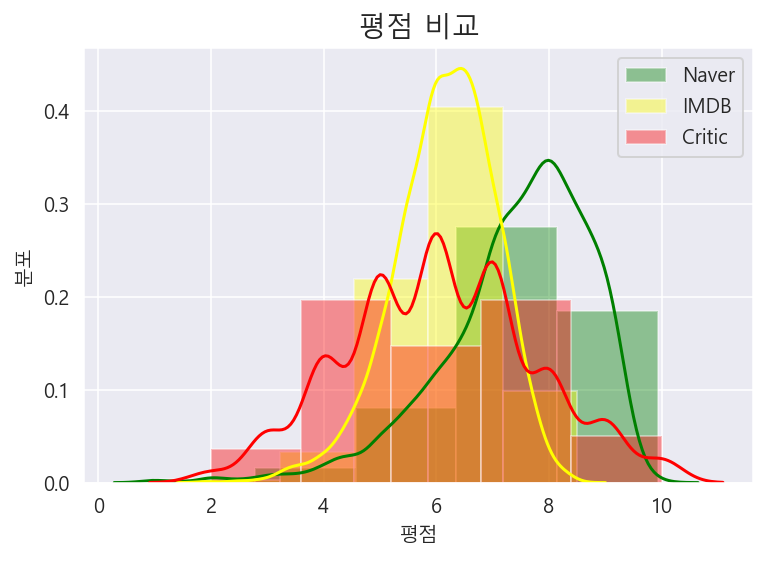

In [11]:
# rating별 비교
sns.distplot(md['naver rating'], color = 'green', bins = 5, label = 'Naver')
sns.distplot(md['imdb rating'], color = 'yellow', bins = 5, label = 'IMDB')
sns.distplot(md['critic_rating'] * 2, color = 'red', bins = 5, label ='Critic')
plt.legend()
plt.title('평점 비교', size = 14)
plt.xlabel('평점')
plt.ylabel('분포')
plt.show()

- ``네이버``: 오른쪽으로 치우쳐진 분포를 볼 수 있습니다. 실제로 네이버의 평점은 다른 서비스들보다 높은 점수대를 이루고 있습니다. 또한 네이버 API를 통해 데이터를 수집하는 과정에서 옛날 영화들 같은 경우엔 평점이 제대로 표기되지 않는 것도 많았습니다.
- ``IMDB``: 네이버와 비교하면 상대적으로 정규분포 모형을 띄고 있습니다. 하지만 평균적인 점수대에 많은 데이터가 몰려 있는 것을 확인할 수 있습니다.
- ``이동진 평론가의 평점``: 정말 정규분포를 이루고 있다는 것에 놀랐습니다..하지만 데이터 수가 적어서 해당 평점을 사용하긴 힘들 것 같습니다.

In [12]:
# 코사인 유사도가 높은 영화 10선 추천
def recom_movie(df, sorted_ind, title_name, top_n=10):
    #  해당 영화 제목의 index 추출
    title_movie = df[df['title'] == title_name]
    title_index = title_movie.index.values
    
    # top_n의 2배에 해당하는 유사성이 높은 index 추출 
    similar_indexes = sorted_ind[title_index, :(top_n*2)]
    similar_indexes = similar_indexes.reshape(-1)
    
    # 기준 영화 index는 제외
    similar_indexes = similar_indexes[similar_indexes != title_index]
    
    # top_n의 2배에 해당하는 후보군에서  rating이 높은 순으로 top_n 만큼 추출 
    return df.iloc[similar_indexes].sort_values('imdb rating', ascending=False)[:top_n][['title', 'publication date', 'imdb rating', 'critic_rating', 'review']]

similar_movies = recom_movie(md, content_sim_sorted_ind, '기생충',10)
similar_movies

,title,publication date,imdb rating,critic_rating,review
3037,밀정,2016,7.7,3.5,뜨거워지는 것을 본능적으로 경계하는 김지운의 성향과 뜨거워질 수밖에 없는 소재의 ...
624,옥자,2017,7.7,4.0,봉준호의 세계에서 희망은 횃불이 아니라 불씨다.
1937,공동경비구역 JSA,2000,7.7,4.0,한국영화계에 이른바 '웰메이드 무비'의 기준을 제시하다.
1530,박쥐,2009,7.0,5.0,"어느 방향에서 보든, 영화적 체험의 강렬한 극단."""
822,괴물,2006,6.7,4.5,기념비적인 충무로 오락영화.
154,설국열차,2013,6.7,3.5,뜨거운 계급투쟁처럼 보였던 차가운 사회생물학. 봉준호의 암연(暗淵).
2819,밀양,2007,6.3,5.0,영화라는 매체가 도달할 수 있는 깊이.
3982,쩨쩨한 로맨스,2010,6.2,2.5,(이선균이라는 토양 위에 세워진) 최강희라는 백화점.
3283,의형제,2010,6.1,3.0,남성 투 톱 영화에서 앙상블 좋은 두 배우를 보는 재미.
3093,하울링,2012,5.9,2.5,시너지는 없었다.


그럴듯해 보이지만 평점의 오류가 발생할 여지가 있습니다. 1명만 투표한 10점짜리의 과연 영화를 신뢰할 수 있을까요? 이를 방지하기 위해서 [IMDB](https://en.wikipedia.org/wiki/IMDb#Rankings)에서 투표 수를 고려한 가중 평점을 구한다고 합니다.

In [13]:
# 투표 수를 고려한 가중 평점 구하는 함수
def weighted_vote_average(record):
    # IMDB 평점이 누락된 데이터
    if np.isnan(record['imdb rating']):
        return round(record['naver rating'] - 1.45, 2)
    
    else: 
        percentile = 0.6
        m = md['vote_count'].quantile(percentile)
        C = md['imdb rating'].mean()
        v = record['vote_count']
        R = record['imdb rating']
    
        return round(((v/(v+m)) * R ) + ( (m/(m+v)) * C ), 2)

- m : 최소 투표 개수
- C : 전체 평균 평점
- v : 해당 영화의 투표 개수
- R: 해당 영화의 평점

In [14]:
# 투표 수를 고려한 가중 평점
md['weighted_rating'] = md.apply(weighted_vote_average, axis=1)

In [47]:
# 
print('상위 20%의 가중평점은?: ', md['weighted_rating'].quantile(0.8))
print('상위 10%의 가중평점은?: ', md['weighted_rating'].quantile(0.9))

상위 20%의 가중평점은?:  6.55
상위 10%의 가중평점은?:  6.96


In [15]:
# 기존 IMDB 평점에 가중 평점을 고려했을 때 평균적으로 -0.077이 낮아진다.
diff = md.loc[~np.isnan(md['imdb rating'])]['imdb rating'] - md.loc[~np.isnan(md['imdb rating'])]['weighted_rating']
diff.mean()

-0.07726712328767135

In [16]:
# 코사인 유사도가 높은 영화 10선 추천
def recom_movie(df, sorted_ind, title_name, top_n=10):
    #  해당 영화 제목의 index 추출
    title_movie = df[df['title'] == title_name]
    title_index = title_movie.index.values
    
    # top_n의 2배에 해당하는 유사성이 높은 index 추출 
    similar_indexes = sorted_ind[title_index, :(top_n*2)]
    similar_indexes = similar_indexes.reshape(-1)
    
    # 기준 영화 index는 제외
    similar_indexes = similar_indexes[similar_indexes != title_index]
    
    # top_n의 2배에 해당하는 후보군에서  rating이 높은 순으로 top_n 만큼 추출 
    similar_movies =  df.iloc[similar_indexes].sort_values('weighted_rating', ascending=False)[:top_n][['title', 'publication date', 'imdb rating', 'vote_count', 'weighted_rating','critic_rating', 'review']]
    similar_movies.rename(columns = {'title' : '제목', 'publication date' : '개봉년도', 'weighted_rating' : '가중 평점', 'critic_rating' : '이동진 평점', 'review' : '이동진의 한줄평'}, inplace = True)
    
    return similar_movies[['제목', '개봉년도', '가중 평점', '이동진 평점', '이동진의 한줄평']]

    # 기생충과 유사한 영화 10개
similar_movies = recom_movie(md, content_sim_sorted_ind, '기생충',10)
similar_movies

,제목,개봉년도,가중 평점,이동진 평점,이동진의 한줄평
4671,살인의 추억,2003,7.96,5.0,한국영화계가 2003년을 자꾸 되돌아보는 가장 큰 이
624,옥자,2017,7.46,4.0,봉준호의 세계에서 희망은 횃불이 아니라 불씨다.
4478,거인,2014,7.41,3.5,성장영화가 아닙니다. 일종의 재난영화입니다.
4600,우아한 세계,2007,6.89,3.0,뛰어난 배우 한 명이 한 작품에서 차지할 수 있는 비중의 극대치.
1937,공동경비구역 JSA,2000,6.83,4.0,한국영화계에 이른바 '웰메이드 무비'의 기준을 제시하다.
4482,사도,2014,6.80,3.5,천둥 같은 분노가 아니라 이슬 같은 무력감. (영조는 사도를 아들이기에 앞서 세자...
154,설국열차,2013,6.67,3.5,뜨거운 계급투쟁처럼 보였던 차가운 사회생물학. 봉준호의 암연(暗淵).
1530,박쥐,2009,6.64,5.0,"어느 방향에서 보든, 영화적 체험의 강렬한 극단."""
822,괴물,2006,6.58,4.5,기념비적인 충무로 오락영화.
3037,밀정,2016,6.44,3.5,뜨거워지는 것을 본능적으로 경계하는 김지운의 성향과 뜨거워질 수밖에 없는 소재의 ...


### 콘텐츠 기반 필터링의 특징
- 다른 유저의 데이터가 필요하지 않다.
- 개인의 독특한 취향을 고려한 추천이 가능하다.
- 협업 필터링에서 발생하는 [콜드 스타트 문제](https://en.wikipedia.org/wiki/Cold_start_(recommender_systems))(협업 필터링에서 새로운 아이템이 추가되었을 때, 평가한 사람이 없어 추천이 어려운 문제)를 자연스럽게 해결할 수 있다.
-  다양한 형식의 항목을 추천하기 어려운 단점
- 처음 유입된 유저에 대해서는 추천할 수 없다.

## 하이브리드 기반 추천

In [17]:
reader = Reader(rating_scale = (1, 5.0) )

ratings = pd.read_csv('ratings_small.csv')
print(ratings.shape)
ratings.head()

(100004, 4)


,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [18]:
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)
trainset, testset = train_test_split(data, test_size = 0.25)

In [19]:
# 특이점 분해
svd = SVD()
svd.fit(trainset)

In [20]:
predictions = svd.test(testset)
print('predictions type: ', type(predictions), 'size: ', len(predictions))
print('최초 5개의 데이터만 추출')
predictions[:5]

predictions type:  <class 'list'> size:  25001
최초 5개의 데이터만 추출


[Prediction(uid=475, iid=90647, r_ui=2.0, est=2.2115278024366583, details={'was_impossible': False}),
 Prediction(uid=56, iid=2953, r_ui=4.0, est=2.6295215216278387, details={'was_impossible': False}),
 Prediction(uid=333, iid=8665, r_ui=4.5, est=4.372291612168417, details={'was_impossible': False}),
 Prediction(uid=90, iid=986, r_ui=4.0, est=3.770991445364404, details={'was_impossible': False}),
 Prediction(uid=509, iid=68, r_ui=4.0, est=3.1247184158145713, details={'was_impossible': False})]

In [21]:
cross_validate(svd, data, measures = ['RMSE', 'MAE'], cv = 5, verbose = True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9032  0.8969  0.8924  0.8957  0.8951  0.8967  0.0036  
MAE (testset)     0.6966  0.6908  0.6840  0.6909  0.6884  0.6901  0.0041  
Fit time          3.99    3.95    3.91    3.85    3.84    3.91    0.06    
Test time         0.12    0.20    0.12    0.19    0.12    0.15    0.04    


{'test_rmse': array([0.90320495, 0.89691548, 0.89236398, 0.89572311, 0.89507005]),
 'test_mae': array([0.69664125, 0.69075223, 0.6840405 , 0.69091832, 0.68836819]),
 'fit_time': (3.9866795539855957,
  3.953923225402832,
  3.906456232070923,
  3.84635066986084,
  3.8368265628814697),
 'test_time': (0.11771845817565918,
  0.20096468925476074,
  0.1156318187713623,
  0.18965363502502441,
  0.12419605255126953)}

In [22]:
def convert_int(x):
    try:
        return int(x)
    except:
        return np.nan

In [23]:
indices = pd.Series(md.index, index=md['title'])

id_map = pd.read_csv('links.csv')[['movieId', 'tmdbId']]
id_map['tmdbId'] = id_map['tmdbId'].apply(convert_int)
id_map.columns = ['movieId', 'id']
id_map = id_map.merge(md[['title', 'id']], on='id').set_index('title')
indices_map = id_map.set_index('id')

In [24]:
def make_plot(user_id):
    try:
        plt.figure(figsize = (8,6))

        user = ratings.loc[ratings['userId'] == user_id]
        user = user.merge(md, left_on = 'movieId', right_on = 'id')

        user = user['genres'].apply(lambda x : x.split())

        array = []
        for items in user:
            for item in items:
                array.append(item)

        user_view = pd.DataFrame()
        user_view['genres'] = array

        count_df = pd.DataFrame(user_view.groupby('genres')['genres'].count().sort_values(ascending = False))
        sns.barplot(data = count_df, x = count_df.index, y = count_df['genres'], palette = 'Paired')
        plt.xticks(rotation = 90)
        plt.xlabel('장르')
        plt.ylabel('영화를 본 횟수')
        plt.title('User ID: ' + str(user_id), size = 14)
        plt.show()
        
    except:
        print('없는 유저입니다. 다른 유저 ID를 검색해주실래요?😥')

In [25]:
def hybrid(userId, title):
     try:
        idx = indices[title]
        tmdbId = id_map.loc[title]['id']
        movie_id = id_map.loc[title]['movieId']

        sim_scores = list(enumerate(cosine_sim[int(idx)]))
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
        sim_scores = sim_scores[1:20]
        movie_indices = [i[0] for i in sim_scores]

        movies = md.iloc[movie_indices][['id', 'title', 'publication date', 'weighted_rating', 'naver rating', 'critic_rating', 'vote_count', 'review']]
        movies['est'] = round(movies['id'].apply(lambda x: svd.predict(userId, indices_map.loc[x]['movieId']).est), 1)
        movies['exp_rating'] = round((movies['est'] * 2 + movies['weighted_rating']) / 2 , 2)
        movies = movies.sort_values(by = 'exp_rating', ascending=False)
        
        # 후보군 중  exp_rating이 높은 순으로 10개의 영화 추천 
        movies.rename(columns = {'title' : '제목', 'publication date' : '개봉년도', 'exp_rating' : '예상 평점', 'critic_rating' : '이동진 평점', 'review' : '이동진의 한줄평'}, inplace = True)
        return movies[['제목', '개봉년도', '예상 평점', '이동진 평점', '이동진의 한줄평']].head(10)

     except:
            print('유저 ID 또는 영화 제목을 다시 한 번 확인해주실래요? 🥺')

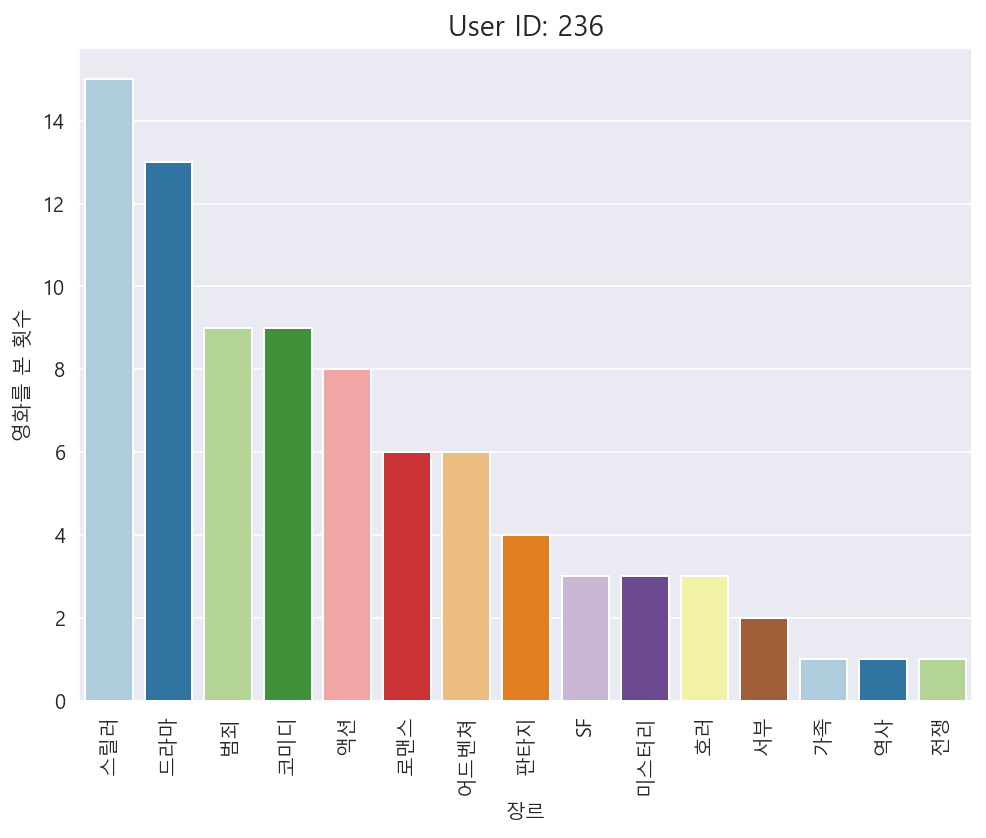

In [26]:
make_plot(236)

In [27]:
hybrid(236, '기생충')

,제목,개봉년도,예상 평점,이동진 평점,이동진의 한줄평
4671,살인의 추억,2003,7.68,5.0,한국영화계가 2003년을 자꾸 되돌아보는 가장 큰 이
624,옥자,2017,7.43,4.0,봉준호의 세계에서 희망은 횃불이 아니라 불씨다.
4478,거인,2014,7.40,3.5,성장영화가 아닙니다. 일종의 재난영화입니다.
154,설국열차,2013,7.24,3.5,뜨거운 계급투쟁처럼 보였던 차가운 사회생물학. 봉준호의 암연(暗淵).
1937,공동경비구역 JSA,2000,7.22,4.0,한국영화계에 이른바 '웰메이드 무비'의 기준을 제시하다.
4600,우아한 세계,2007,7.14,3.0,뛰어난 배우 한 명이 한 작품에서 차지할 수 있는 비중의 극대치.
4482,사도,2014,7.10,3.5,천둥 같은 분노가 아니라 이슬 같은 무력감. (영조는 사도를 아들이기에 앞서 세자...
3037,밀정,2016,6.92,3.5,뜨거워지는 것을 본능적으로 경계하는 김지운의 성향과 뜨거워질 수밖에 없는 소재의 ...
1530,박쥐,2009,6.92,5.0,"어느 방향에서 보든, 영화적 체험의 강렬한 극단."""
822,괴물,2006,6.89,4.5,기념비적인 충무로 오락영화.


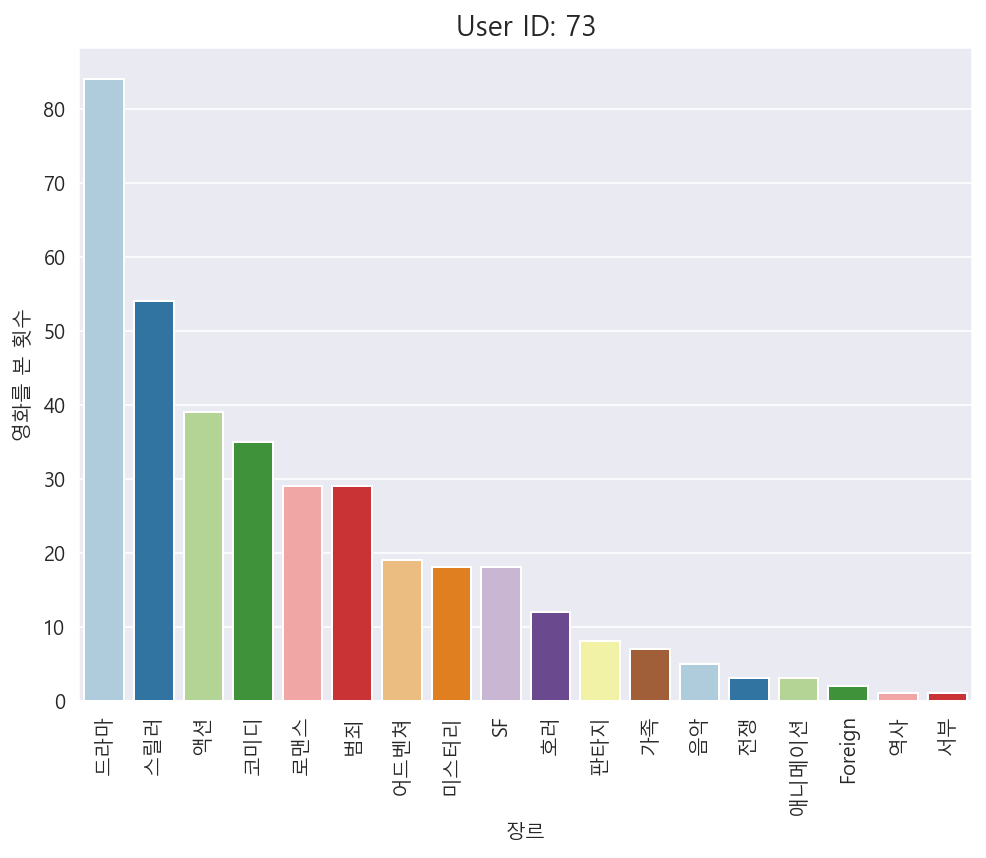

In [28]:
make_plot(73)

In [29]:
hybrid(73, '기생충')

,제목,개봉년도,예상 평점,이동진 평점,이동진의 한줄평
4671,살인의 추억,2003,7.38,5.0,한국영화계가 2003년을 자꾸 되돌아보는 가장 큰 이
154,설국열차,2013,7.14,3.5,뜨거운 계급투쟁처럼 보였던 차가운 사회생물학. 봉준호의 암연(暗淵).
624,옥자,2017,7.13,4.0,봉준호의 세계에서 희망은 횃불이 아니라 불씨다.
4478,거인,2014,7.10,3.5,성장영화가 아닙니다. 일종의 재난영화입니다.
4600,우아한 세계,2007,6.84,3.0,뛰어난 배우 한 명이 한 작품에서 차지할 수 있는 비중의 극대치.
4482,사도,2014,6.80,3.5,천둥 같은 분노가 아니라 이슬 같은 무력감. (영조는 사도를 아들이기에 앞서 세자...
822,괴물,2006,6.69,4.5,기념비적인 충무로 오락영화.
1530,박쥐,2009,6.62,5.0,"어느 방향에서 보든, 영화적 체험의 강렬한 극단."""
3037,밀정,2016,6.62,3.5,뜨거워지는 것을 본능적으로 경계하는 김지운의 성향과 뜨거워질 수밖에 없는 소재의 ...
3464,화차,2012,6.53,3.5,한 순간도 핵심에서 벗어나지 않는다.
